CS-E5885 Modeling biological networks (spring 2023)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('data.csv', header = 0)

In [3]:
data.head()

,Time/gene,SWI5,CBF1,GAL4,GAL80,ASH1
0,0,0.0760,0.0419,0.0207,0.0225,0.1033
1,10,0.0186,0.0365,0.0122,0.0175,0.0462
2,20,0.0090,0.0514,0.0073,0.0165,0.0439
3,30,0.0117,0.0473,0.0079,0.0147,0.0371
4,40,0.0088,0.0482,0.0084,0.0145,0.0475


In [4]:
t_data = data['Time/gene'].to_numpy()
Y_data = data.drop(columns = ['Time/gene']).to_numpy()

## First view of the data

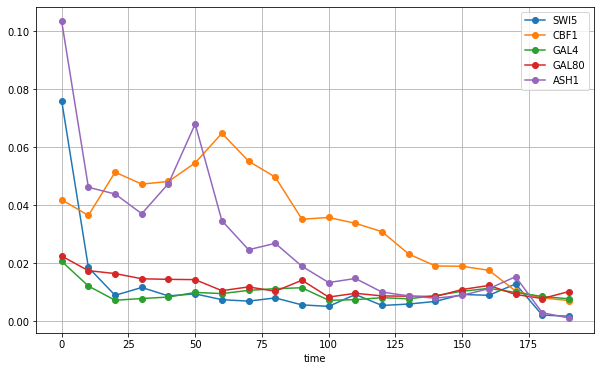

In [5]:
#observe data

plt.figure(figsize=(10,6))
plt.plot(t_data, Y_data, marker = "o")
plt.legend(data.columns[1:])
plt.xlabel('time')
plt.grid()
plt.show()

In [6]:
#observations:

## exo 5

## Choice of the first model - density karnel and arcne algorithm

#### Karnel dentsity to estimat the density of our data

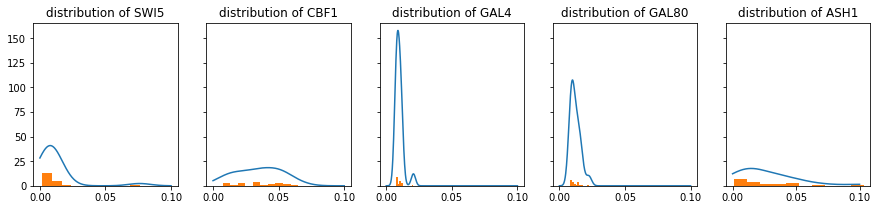

In [7]:
from scipy.stats import norm, gaussian_kde

#preparing the plot
t = np.linspace(0, 0.1, 500)
fig, axs = plt.subplots(1, 5,figsize=(15, 3), sharey=True)

#init list of karnel density for each varrible
densities = []

#the bandwith 
bw = []


for i in range(Y_data.shape[1]) : #for each genes
    
    #estimate the ditribution
    scipy_karnel = gaussian_kde(Y_data[:,i])
    densities.append(scipy_karnel)
    y= scipy_karnel.evaluate(t)
    
    #plot the histogram of the y values and the distributions
    axs[i].plot(t,y)
    axs[i].hist(Y_data[:,i])

    #title and legend
    axs[i].set_title(f'distribution of {data.columns[1+i]}')
    
    #estimate the bandwith
    bw.append(scipy_karnel.factor * np.std(Y_data[:,i]))

#### Mutual information computation

In [8]:
#mutual information is given by sum(p(x,y) log(p(x,y)/p(x)p(y)))

def MI(pmfx,pmfy) : 
    '''
    Compute the mutual inforamtion between the varriable X and Y using their probability 
    mass function. and the joint probability mass function.
    
    pmfx : probability mass function of X
    pmfy : probability mass funciton of Y
    
    return float
    '''

#### Multistart algorithm for the first model

Our model is represented by a matrix 5x5 composed by 1 or 0. The element $M_{ij} = 1$ means gene i impact gene j.

We're going to generate 3 starting matrix using the observation that we can do about the data behavor and the biological knowlege that we have.
- we can oberve that varriables seems more correlated than others. Behavor of Gal4 and Gal80 (elements 3 and 4 of the data) seems the same. we will generate randomly with a proba p = 0.8 to have a 1 between element i,j = {3,4}.
- We want to remove the auto-regulation

In [113]:
def multistart_generation(N):
    '''
    generate a list of N starting matrix according to the condition.
    
    return : 
    list of N matrix 5x5 with 1 or 0 value
    '''
    M = []
    for i in range(N): M.append(np.zeros((5,5)))
    
    for m in M:
        for i in range(5) :
            for j in range(5):
                if (j == 3 or j== 4) and (i==3 or i == 4) : 
                    m[i][j] = np.random.choice([0, 1], p=[.2, .8]) #gal4 and gal80 may interact
                else : m[i][j] = np.random.choice([0, 1], p=[.5, .5]) 
                
                if i == j : m[i][j] = 0 #remove the auto-regulation
                
    return M

we can visualize our matrix using a confusion metrics

In [114]:
import networkx as nx

def vizualize_model(m, index):
    '''
    vizualize the structure of the model m
    
    paramter: 
    m: model matrix 5x5
    
    return: 
    non
    
    '''
    label = data.columns[1:]
    G = nx.DiGraph() #creat a directed graph
    
    G.add_nodes_from(label)
    
    for i in range(m.shape[0]) :
        for j in range(m.shape[1]):
            if m[i][j] ==1 : G.add_edge(label[i], label[j], weight=1)
                
    pos = nx.spring_layout(G)          
    nx.draw_networkx_labels(G,pos)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'),node_color = "pink", node_size = 500)
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)
    plt.title(f"starting model strucutre {index +1}")
    plt.show()


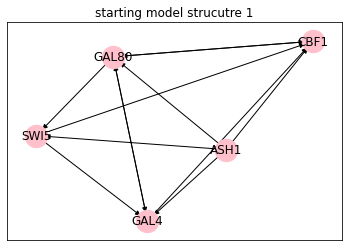

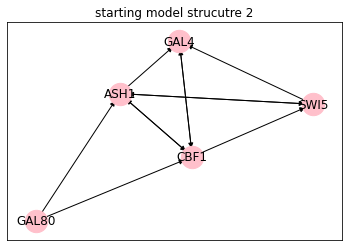

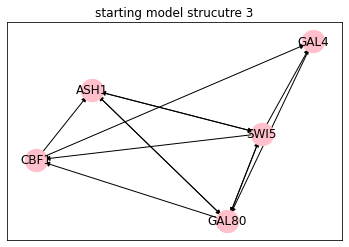

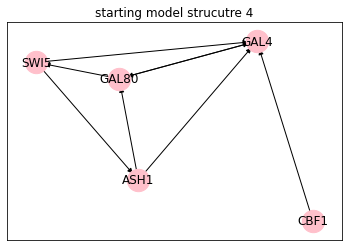

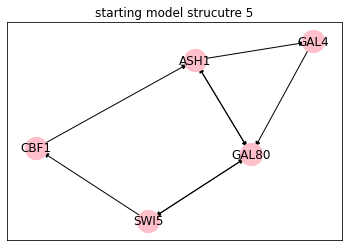

In [136]:
#TEST : 
M = multistart_generation(5)
for i in range(len(M)) : 
    vizualize_model(M[i], i)

In [137]:
#vizalization of the average of the interactions
M_average = sum(M)/len(M)
average_data = pd.DataFrame(M_average, index=data.columns[1:], columns=data.columns[1:])
average_data.head()

,SWI5,CBF1,GAL4,GAL80,ASH1
SWI5,0.0,0.6,0.8,0.4,0.6
CBF1,0.2,0.0,0.6,0.2,0.6
GAL4,0.0,0.4,0.0,0.8,0.0
GAL80,0.8,0.6,0.4,0.0,0.6
ASH1,0.6,0.4,0.8,0.8,0.0


## Structure optimization : voisin algo and bootstramp

We're using the greedy hill algorithm to find the best structure for our system. We're optimize the matrix M.

In [138]:
def greedy_hill_climbing(M) :
    ''' 
    Creat the neighboring of M and give the optimized graphe.
    
    parameter : 
    M: the starting graph
    
    return : 
    M_otp the optimized graph
    '''
    nhb = neighborhood(M)
    M_opt = M
    
    for m in nhb:
        if score(m) > score(M_opt) : M_opt = m
    
    return M_opt

In [139]:
def neighborhood(M):
    '''
    compute the newborns of M.  
    - add a reaction 0->1
    - delete a reaction 1->0
    
    parameter :
    M : the initial strucutre
    
    return:
    nhb : list of the neihgbor of M. size = size(M)*size(M)
    '''
    M_ = M # a copy of M
    nhb = []
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if M[i][j] ==0 : M_[i][j]= 1
            else : M_[i][j]= 0
            nhb.append(M_) #add the neighbor of M 
            M_ = M #come back to M to change the next value at the next step
            
    return nhb

In [140]:
#TEST
opt_M = []
s = []
for m in M : 
    opt_M.append(greedy_hill_climbing(m)) #we run the algorithm for each of the starting matrix 
    s.append(score(M)) #compute the score of the optimized matrix

best_M = opt_M[s.index(max(s))]

## ODE and optimization of the parameters k 

## Compute the score with likelihood and BIC

In [119]:
def score(M):
    '''
    cumpute the score of a graph
    
    '''
    return 0